In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm

import os

In [173]:
# import kagglehub

# # Specify the download directory (adjust this to your desired path)
# download_dir = os.getcwd() + "\data"

# # Download the dataset to the specified directory
# path = kagglehub.dataset_download("kylegraupe/spy-daily-eod-options-quotes-2020-2022", path=download_dir)

# print("Dataset downloaded to:", path)


In [174]:

def black_scholes_price(S, K, T, r, sigma, option_type='call', q=0.015):
    if T <= 0 or sigma <= 0:
        if option_type == 'call':
            return max(S - K, 0.0)
        else:
            return max(K - S, 0.0)

    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)


In [175]:

# Improved backtest logic with call-only filter and debug logs

def backtest_strategy(data, threshold=0.01, r=0.05, q=0.015):
    cash = 0.0
    position = None
    entry_price = 0.0
    position_type = None
    history = []

    # Only use call options for now
    data = data[data['optionType'] == 'call'].copy()

    for idx, row in data.iterrows():
        S = row['underlyingPrice']
        K = row['strike']
        T = row['dte'] / 365.0  # Convert to years
        market_price = row['mark']
        sigma = row['impliedVolatility'] / 100
        opt_type = row['optionType']

        model_price = black_scholes_price(S, K, T, r, sigma, option_type=opt_type, q=q)
        diff = (model_price - market_price) / model_price

        print(f"Date: {row['quote_datetime']}, Model: {model_price:.2f}, Market: {market_price:.2f}, Diff: {diff:.4f}")

        # Close existing position if signal reverses
        if position:
            if (position_type == 'long' and diff < -threshold) or \
               (position_type == 'short' and diff > threshold) or T <= 0:
                pnl = (market_price - entry_price) if position_type == 'long' else (entry_price - market_price)
                cash += pnl
                print(f"\tClosed {position_type.upper()} @ {market_price:.2f}, PnL: {pnl:.2f}")
                position = None
                position_type = None

        # Open new position if no position held
        if not position:
            if diff > threshold:
                position = 1
                entry_price = market_price
                position_type = 'long'
                print(f"\tOpened LONG @ {market_price:.2f}")
            elif diff < -threshold:
                position = 1
                entry_price = market_price
                position_type = 'short'
                print(f"\tOpened SHORT @ {market_price:.2f}")

        net_value = cash
        if position:
            current_pnl = (market_price - entry_price) if position_type == 'long' else (entry_price - market_price)
            net_value += current_pnl

        history.append({
            'date': row['quote_datetime'],
            'cash': cash,
            'net_value': net_value,
            'position': position_type,
            'market_price': market_price,
            'model_price': model_price
        })

    return pd.DataFrame(history)


In [176]:

# --------------------------
# Compute Backtest Performance Metrics
# --------------------------
def backtest_metrics(sim_df):
    """
    Compute performance metrics based on the backtest pnl.

    Returns a dictionary with total return, annualized return/volatility, Sharpe ratio, and max drawdown.
    """
    pnl = sim_df['net_value']
    returns = pnl.pct_change().fillna(0)
    total_return = pnl.iloc[-1] / pnl.iloc[0] - 1
    annualized_return = (1 + total_return) ** (252 / len(pnl)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else np.nan
    max_drawdown = (pnl.cummax() - pnl).max() / pnl.cummax().max()
    metrics = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }
    return metrics


In [177]:
# --------------------------
# 3D Black-Scholes Surface Plot
# --------------------------
def plot_black_scholes_surface(F=100, sigma=0.2, r=0.01, option_type='call'):
    """
    Plot a 3D surface of Black-Scholes option prices as a function of strike price and time to expiration.
    
    Parameters:
      F : float
          Fixed underlying price.
      sigma : float
          Volatility.
      r : float
          Risk-free rate.
      option_type : 'call' or 'put'
          Option type.
    """
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Grid of strike prices and time-to-expiration values.
    K = np.linspace(80, 120, 50)
    T = np.linspace(0.01, 1, 50)
    K_grid, T_grid = np.meshgrid(K, T)
    
    # Compute option prices on the grid
    prices = black_model_option(F, K_grid, T_grid, sigma, r, option_type)
    
    surf = ax.plot_surface(K_grid, T_grid, prices, cmap=cm.viridis, edgecolor='none')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Time to Expiration (years)')
    ax.set_zlabel('Option Price')
    ax.set_title('Black-Scholes Option Pricing Surface')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


In [178]:


# Load the CSV file with low_memory=False to avoid DtypeWarnings.
df_options = pd.read_csv('data/spy_2020_2022.csv', low_memory=False)

# Clean up column names using a regex to remove square brackets.
df_options.columns = df_options.columns.str.strip().str.replace(r'[\[\]]', '', regex=True)

# Clean the C_IV column:
# 1. Convert to string (if not already), 
# 2. Strip extra spaces, 
# 3. Then convert to numeric.
df_options['C_IV'] = df_options['C_IV'].astype(str).str.strip()
df_options['C_IV'] = pd.to_numeric(df_options['C_IV'], errors='coerce')


# Rename columns to match expected names for backtesting.
rename_map = {
    'QUOTE_DATE': 'snapshotDate',
    'EXPIRE_DATE': 'expirationDate',
    'UNDERLYING_LAST': 'underlyingPrice',
    'DTE': 'dte',
    'STRIKE': 'strike',
    'C_BID': 'C_bid',
    'C_ASK': 'C_ask',
    'C_IV': 'impliedVolatility'
}
df_options = df_options.rename(columns=rename_map)

# Convert other key columns to numeric.
for col in ['underlyingPrice', 'dte', 'strike', 'C_bid', 'C_ask']:
    df_options[col] = pd.to_numeric(df_options[col], errors='coerce')

# Create the 'mark' column as the average of C_bid and C_ask.
df_options['mark'] = (df_options['C_bid'] + df_options['C_ask']) / 2

# Impute missing impliedVolatility with the column's mean
df_options['impliedVolatility'] = df_options['impliedVolatility'].fillna(df_options['impliedVolatility'].mean())

# Create a 'CALL' column (assuming these rows are for calls)
df_options['CALL'] = True

# Display the cleaned DataFrame (first few rows)
print("\nCleaned DataFrame (first 5 rows):")
print(df_options[['snapshotDate', 'expirationDate', 'underlyingPrice', 'dte', 'strike', 'mark', 'impliedVolatility', 'CALL']].head())



Cleaned DataFrame (first 5 rows):
  snapshotDate expirationDate  underlyingPrice  dte  strike    mark  \
0   2021-09-01     2021-09-01           451.85  0.0   270.0  181.70   
1   2021-09-01     2021-09-01           451.85  0.0   275.0  176.70   
2   2021-09-01     2021-09-01           451.85  0.0   280.0  171.70   
3   2021-09-01     2021-09-01           451.85  0.0   285.0  166.72   
4   2021-09-01     2021-09-01           451.85  0.0   290.0  161.70   

   impliedVolatility  CALL  
0           0.344439  True  
1           0.344439  True  
2           0.344439  True  
3           0.344439  True  
4           0.344439  True  


Number of rows in backtest_df: 758
Length of positions list: 758
Backtest Performance Metrics:
Total Return: 0.00%
Annualized Return: 0.00%
Annualized Volatility: 0.00%
Sharpe Ratio: nan%
Max Drawdown: 0.00%

Executed Trades:
(Timestamp('2020-01-02 00:00:00'), 'Sell Short', 16.32)
(Timestamp('2020-01-03 00:00:00'), 'Sell Short', 3.1900000000000004)
(Timestamp('2020-01-06 00:00:00'), 'Sell Short', 2.67)
(Timestamp('2020-01-07 00:00:00'), 'Sell Short', 3.3449999999999998)
(Timestamp('2020-01-08 00:00:00'), 'Sell Short', 1.1749999999999998)
(Timestamp('2020-01-09 00:00:00'), 'Sell Short', 2.66)
(Timestamp('2020-01-10 00:00:00'), 'Sell Short', 2.66)
(Timestamp('2020-01-13 00:00:00'), 'Sell Short', 11.695)
(Timestamp('2020-01-14 00:00:00'), 'Sell Short', 2.005)
(Timestamp('2020-01-15 00:00:00'), 'Sell Short', 15.559999999999999)
(Timestamp('2020-01-16 00:00:00'), 'Sell Short', 15.205)
(Timestamp('2020-01-17 00:00:00'), 'Sell Short', 15.309999999999999)
(Timestamp('2020-01-21 00:00:00'), 'Se

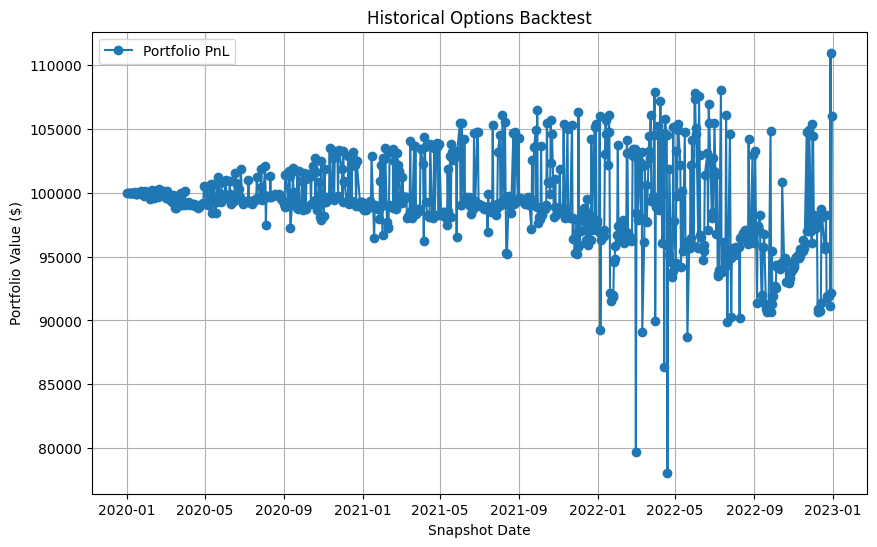

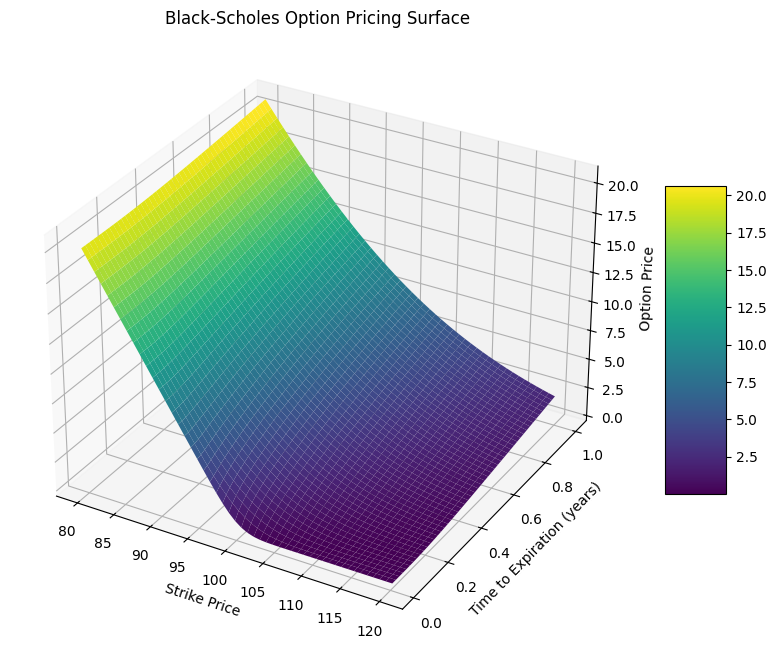

In [179]:

# Run the backtest
backtest_df, trades = backtest_historical_options(df_options, threshold=0.005, initial_cash=100000, r=0.01)


# Print performance statistics
print("Backtest Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.2%}")

print("\nExecuted Trades:")
for trade in trades:
    print(trade)

# Plot the portfolio PnL over time
plt.figure(figsize=(10,6))
plt.plot(backtest_df['snapshotDate'], backtest_df['pnl'], marker='o', label='Portfolio PnL')
plt.xlabel('Snapshot Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Historical Options Backtest')
plt.legend()
plt.grid(True)
plt.show()

# Plot the 3D Black-Scholes pricing surface
plot_black_scholes_surface(F=100, sigma=0.2, r=0.01, option_type='call')